新增3局接chatgpt

In [1]:
import os
import pandas as pd
from selenium import webdriver
from time import sleep
from datetime import datetime, timedelta, date
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import smtplib
import os
from dotenv import load_dotenv
load_dotenv()
from openai import OpenAI

SENDER_EMAIL = os.getenv('SENDER_EMAIL')
GMAIL_KEY = os.getenv('GMAIL_KEY')
MAIL_TO = os.getenv('MAIL_TO')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

print(f"寄件者：{SENDER_EMAIL}")
print(f"收件者：{MAIL_TO}")
print(f"gmail金鑰：{GMAIL_KEY[:4]}...(略)")
print(f"gpt金鑰：{OPENAI_API_KEY[:4]}...(略)")

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    organization=os.getenv("organization"),      # 加入你的組織 ID
    project= os.getenv("project_id")           # 加入你的專案 ID（僅適用於 project key）
)

def summarize_text(text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "你是一個專業的文章摘要助手，請提取文章的重點。"},
                {"role": "user", "content": f"請幫我摘要以下文章的重點, 200字以內：{text}"}
            ],
            temperature=0.5,
            max_tokens=150
        )
        return response.choices[0].message.content.strip().replace('\n', ' ')
    except Exception as e:
        print(f"⚠️ GPT 摘要錯誤：{e}")
        return "❌ 摘要失敗"
### -------- 共用設定 -------- ###
def init_driver():
    chrome_version = os.listdir(r"C:\Program Files\Google\Chrome\Application")[0].split('.')[0]
    options = webdriver.ChromeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    driver = webdriver.Chrome(options=options)
    driver.maximize_window()
    return driver
### -------- 共用設定查詢間隔 -------- ###
startday = date.today() - timedelta(days=30)
top_keywords = ['銀行股份有限公司', '證券', '期貨', '投信', '保險', '金融控股', '金控', '銀行', '投顧']

### -------- 爬金管會主網站 -------- ###
def crawl_main_site(driver):
    url = 'https://www.fsc.gov.tw/ch/home.jsp?id=131&parentpath=0,2'
    driver.get(url)
    driver.implicitly_wait(5)

    newlist = []
    for item in range(2, 17):
        try:
            date_text = driver.find_element('css selector', f'#messageform > div.newslist > ul > li:nth-child({item}) > span.date').text
            unit_text = driver.find_element('css selector', f'#messageform > div.newslist > ul > li:nth-child({item}) > span.unit').text
            link = driver.find_element('css selector', f'#messageform > div.newslist > ul > li:nth-child({item}) > span.title > a')
            title_text = link.get_attribute('title')
            href = link.get_attribute('href')
            date_obj = datetime.strptime(date_text, "%Y-%m-%d").date()

            if date_obj >= startday:
                link.click()
                title = driver.find_element('css selector', '#ap > div.maincontent > div.subject > h3').text
                content = driver.find_element('css selector', '#ap > div.maincontent > div.page-edit ').text
                driver.back()
                sleep(1)
                try:
                    summary = summarize_text(content)
                except Exception as e:
                    summary = "❌ 摘要失敗"
                    print(f"⚠️ GPT 摘要錯誤：{e}")

                newlist.append({
                    '編號': len(newlist) + 1,
                    '發布日期': date_text,
                    '資料來源': unit_text,
                    '標題': f'<a href="{href}" target="_blank">{title_text}</a>',
                    '內容': content,
                    '摘要': summary
                })
        except Exception as e:
            continue

    return pd.DataFrame(newlist) if newlist else pd.DataFrame()


### -------- 爬三個子網站 -------- ###
def crawl_sub_sites(driver):
    url_list = [
        'https://www.sfb.gov.tw/ch/home.jsp?id=104&parentpath=0,2,102',
        'https://www.banking.gov.tw/ch/home.jsp?id=550&parentpath=0,524,547',
        'https://www.ib.gov.tw/ch/home.jsp?id=264&parentpath=0,2,262']
    
    burea_list = ['證期局', '銀行局', '保險局']
    output = []

    for i in range(3):
        url = url_list[i]
        bureau = burea_list[i]
        driver.get(url)
        driver.implicitly_wait(5)

        for item in range(5, 33, 2):
            try:
                date_text = driver.find_element('css selector', f'#messageform > div:nth-child(7) > div:nth-child({item}) > div.pdate1').text
                title_element = driver.find_element('css selector', f'#messageform > div:nth-child(7) > div:nth-child({item}) > div.ptitle1 > a')
                title_text = title_element.text
                href = title_element.get_attribute('href')
                date_obj = datetime.strptime(date_text, "%Y-%m-%d").date()

                if date_obj >= startday and any(keyword in title_text for keyword in top_keywords):
                    title_element.click()
                    title = driver.find_element('css selector', '#maincontent > div:nth-child(1) > h3').text
                    content = driver.find_element('css selector', '#maincontent > div.page_content > div:nth-child(2)').text
                    driver.back()
                    sleep(2)
                    try:
                        summary = summarize_text(content)
                    except Exception as e:
                        summary = "❌ 摘要失敗"
                        print(f"⚠️ GPT 摘要錯誤：{e}")
                    output.append({'資料來源': bureau,
                                   '編號': len(output) + 1,
                                   '發布日期': date_text,
                                   '標題': f'<a href="{href}" target="_blank">{title_text}</a>',
                                   '內容': content,
                                   '摘要': summary})
            except Exception:
                continue

    return pd.DataFrame(output) if output else pd.DataFrame()


### -------- Email 寄送功能 -------- ###

def send_email(df, title):
    if df.empty:
        print(f"📭 無{title}，已略過寄信")
        return  # 中止函數，不發送 email

    # 以下為原本的 email 寄送內容（略）
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    import smtplib

    msg = MIMEMultipart()
    msg['Subject'] = title
    msg['From'] = SENDER_EMAIL
    msg['To'] = MAIL_TO
    df['內容'] = df['內容'].str.replace('\n', '<br>')
    html_content = f"""
        <html>
        <head>
            <style>
            table {{
                border-collapse: collapse;
                width: 100%;
                margin: 20px 0; }}
           
            th {{
                background-color: #1a237e;
                color: white;
                text-align: center;
                padding: 12px;
                border: 1px solid #ddd;}}
            
            td {{
                border: 1px solid #ddd;
                padding: 12px;
                text-align: left;
                vertical-align: top;
                white-space: pre-line;}}
            
            tr:nth-child(even) {{
                background-color: #f2f2f2; }}
           
            h3 {{text-align: center;
                color: #333;
                margin: 20px 0;}}
                
            
            </style>
        </head>
        <body>
            <h3>{title}</h3>
            {df.to_html(index=False, escape=False)}
        </body>
        </html>"""
 
    msg.attach(MIMEText(html_content, 'html', 'utf-8'))

    try:
        smtp_server = smtplib.SMTP('smtp.gmail.com', 587)
        smtp_server.starttls()
        smtp_server.login(SENDER_EMAIL, GMAIL_KEY)
  # 建議放進環境變數或 .env 檔
        smtp_server.send_message(msg)
        smtp_server.quit()
        print(f'✅ 郵件發送成功：{title}')
    except Exception as e:
        print(f'❌ 郵件發送失敗：{e}')


### -------- 主程式 -------- ###
def main():
    driver = init_driver()

    # 主站（重大裁罰）
    df_main = crawl_main_site(driver)
    send_email(df_main, '金管會重大裁罰')

    # 三局（非重大裁罰）
    df_sub = crawl_sub_sites(driver)
    send_email(df_sub, '金管會非重大裁罰')

    driver.quit()


if __name__ == "__main__":
    main()

寄件者：lc.sabrinachi@gmail.com
收件者：lc.sabrinachi@gmail.com,sabrina.chi@kgi.com
gmail金鑰：cuer...(略)
gpt金鑰：sk-p...(略)
📭 無金管會重大裁罰，已略過寄信
✅ 郵件發送成功：金管會非重大裁罰


金管會裁罰案接chatgpt

In [2]:
import os
import pandas as pd
from selenium import webdriver
from time import sleep
from datetime import datetime, timedelta, date
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import smtplib
import os
from dotenv import load_dotenv
load_dotenv()
from openai import OpenAI

SENDER_EMAIL = os.getenv('SENDER_EMAIL')
GMAIL_KEY = os.getenv('GMAIL_KEY')
MAIL_TO = os.getenv('MAIL_TO')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

print(f"寄件者：{SENDER_EMAIL}")
print(f"收件者：{MAIL_TO}")
print(f"gmail金鑰：{GMAIL_KEY[:4]}...(略)")
print(f"gpt金鑰：{OPENAI_API_KEY[:4]}...(略)")

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    organization=os.getenv("organization"),      # 加入你的組織 ID
    project= os.getenv("project_id")           # 加入你的專案 ID（僅適用於 project key）
)

def summarize_text(text):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "你是一個專業的文章摘要助手，請提取文章的重點。"},
                {"role": "user", "content": f"請幫我摘要以下文章的重點, 200字以內：{text}"}
            ],
            temperature=0.5,
            max_tokens=150
        )
        return response.choices[0].message.content.strip().replace('\n', ' ')
    except Exception as e:
        print(f"⚠️ GPT 摘要錯誤：{e}")
        return "❌ 摘要失敗"
### -------- 共用設定 -------- ###
def init_driver():
    chrome_version = os.listdir(r"C:\Program Files\Google\Chrome\Application")[0].split('.')[0]
    options = webdriver.ChromeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    driver = webdriver.Chrome(options=options)
    driver.maximize_window()
    return driver
### -------- 共用設定查詢間隔 -------- ###
startday = date.today() - timedelta(days=40)
top_keywords = ['銀行股份有限公司', '證券', '期貨', '投信', '保險', '金融控股', '金控', '銀行', '投顧']

### -------- 爬金管會主網站 -------- ###
def crawl_main_site(driver):
    url = 'https://www.fsc.gov.tw/ch/home.jsp?id=131&parentpath=0,2'
    driver.get(url)
    driver.implicitly_wait(5)

    newlist = []
    for item in range(2, 17):
        try:
            date_text = driver.find_element('css selector', f'#messageform > div.newslist > ul > li:nth-child({item}) > span.date').text
            unit_text = driver.find_element('css selector', f'#messageform > div.newslist > ul > li:nth-child({item}) > span.unit').text
            link = driver.find_element('css selector', f'#messageform > div.newslist > ul > li:nth-child({item}) > span.title > a')
            title_text = link.get_attribute('title')
            href = link.get_attribute('href')
            date_obj = datetime.strptime(date_text, "%Y-%m-%d").date()

            if date_obj >= startday:
                link.click()
                title = driver.find_element('css selector', '#ap > div.maincontent > div.subject > h3').text
                content = driver.find_element('css selector', '#ap > div.maincontent > div.page-edit ').text
                driver.back()
                sleep(1)
                try:
                    summary = summarize_text(content)
                except Exception as e:
                    summary = "❌ 摘要失敗"
                    print(f"⚠️ GPT 摘要錯誤：{e}")

                newlist.append({
                    '編號': len(newlist) + 1,
                    '發布日期': date_text,
                    '資料來源': unit_text,
                    '標題': f'<a href="{href}" target="_blank">{title_text}</a>',
                    '內容': content,
                    '摘要': summary
                })
        except Exception as e:
            continue

    return pd.DataFrame(newlist) if newlist else pd.DataFrame()


### -------- 爬三個子網站 -------- ###
def crawl_sub_sites(driver):
    url_list = [
        'https://www.sfb.gov.tw/ch/home.jsp?id=104&parentpath=0,2,102',
        'https://www.banking.gov.tw/ch/home.jsp?id=550&parentpath=0,524,547',
        'https://www.ib.gov.tw/ch/home.jsp?id=264&parentpath=0,2,262']
    
    burea_list = ['證期局', '銀行局', '保險局']
    output = []

    for i in range(3):
        url = url_list[i]
        bureau = burea_list[i]
        driver.get(url)
        driver.implicitly_wait(5)

        for item in range(5, 33, 2):
            try:
                date_text = driver.find_element('css selector', f'#messageform > div:nth-child(7) > div:nth-child({item}) > div.pdate1').text
                title_element = driver.find_element('css selector', f'#messageform > div:nth-child(7) > div:nth-child({item}) > div.ptitle1 > a')
                title_text = title_element.text
                href = title_element.get_attribute('href')
                date_obj = datetime.strptime(date_text, "%Y-%m-%d").date()

                if date_obj >= startday and any(keyword in title_text for keyword in top_keywords):
                    title_element.click()
                    title = driver.find_element('css selector', '#maincontent > div:nth-child(1) > h3').text
                    content = driver.find_element('css selector', '#maincontent > div.page_content > div:nth-child(2)').text
                    driver.back()
                    sleep(2)

                    output.append({'資料來源': bureau,
                                   '編號': len(output) + 1,
                                   '發布日期': date_text,
                                   '標題': f'<a href="{href}" target="_blank">{title_text}</a>',
                                   '內容': content})
                        
                    
            except Exception:
                continue

    return pd.DataFrame(output) if output else pd.DataFrame()


### -------- Email 寄送功能 -------- ###

def send_email(df, title):
    if df.empty:
        print(f"📭 無{title}，已略過寄信")
        return  # 中止函數，不發送 email

    # 以下為原本的 email 寄送內容（略）
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    import smtplib

    msg = MIMEMultipart()
    msg['Subject'] = title
    msg['From'] = SENDER_EMAIL
    msg['To'] = MAIL_TO
    df['內容'] = df['內容'].str.replace('\n', '<br>')
    html_content = f"""
        <html>
        <head>
            <style>
            table {{
                border-collapse: collapse;
                width: 100%;
                margin: 20px 0; }}
           
            th {{
                background-color: #1a237e;
                color: white;
                text-align: center;
                padding: 12px;
                border: 1px solid #ddd;}}
            
            td {{
                border: 1px solid #ddd;
                padding: 12px;
                text-align: left;
                vertical-align: top;
                white-space: pre-line;}}
            
            tr:nth-child(even) {{
                background-color: #f2f2f2; }}
           
            h3 {{text-align: center;
                color: #333;
                margin: 20px 0;}}
                
            
            </style>
        </head>
        <body>
            <h3>{title}</h3>
            {df.to_html(index=False, escape=False)}
        </body>
        </html>"""
 
    msg.attach(MIMEText(html_content, 'html', 'utf-8'))

    try:
        smtp_server = smtplib.SMTP('smtp.gmail.com', 587)
        smtp_server.starttls()
        smtp_server.login(SENDER_EMAIL, GMAIL_KEY)
  # 建議放進環境變數或 .env 檔
        smtp_server.send_message(msg)
        smtp_server.quit()
        print(f'✅ 郵件發送成功：{title}')
    except Exception as e:
        print(f'❌ 郵件發送失敗：{e}')


### -------- 主程式 -------- ###
def main():
    driver = init_driver()

    # 主站（重大裁罰）
    df_main = crawl_main_site(driver)
    send_email(df_main, '金管會重大裁罰')

    # 三局（非重大裁罰）
    df_sub = crawl_sub_sites(driver)
    send_email(df_sub, '金管會非重大裁罰')

    driver.quit()


if __name__ == "__main__":
    main()

寄件者：lc.sabrinachi@gmail.com
收件者：lc.sabrinachi@gmail.com,sabrina.chi@kgi.com
gmail金鑰：cuer...(略)
gpt金鑰：sk-p...(略)
✅ 郵件發送成功：金管會重大裁罰
✅ 郵件發送成功：金管會非重大裁罰


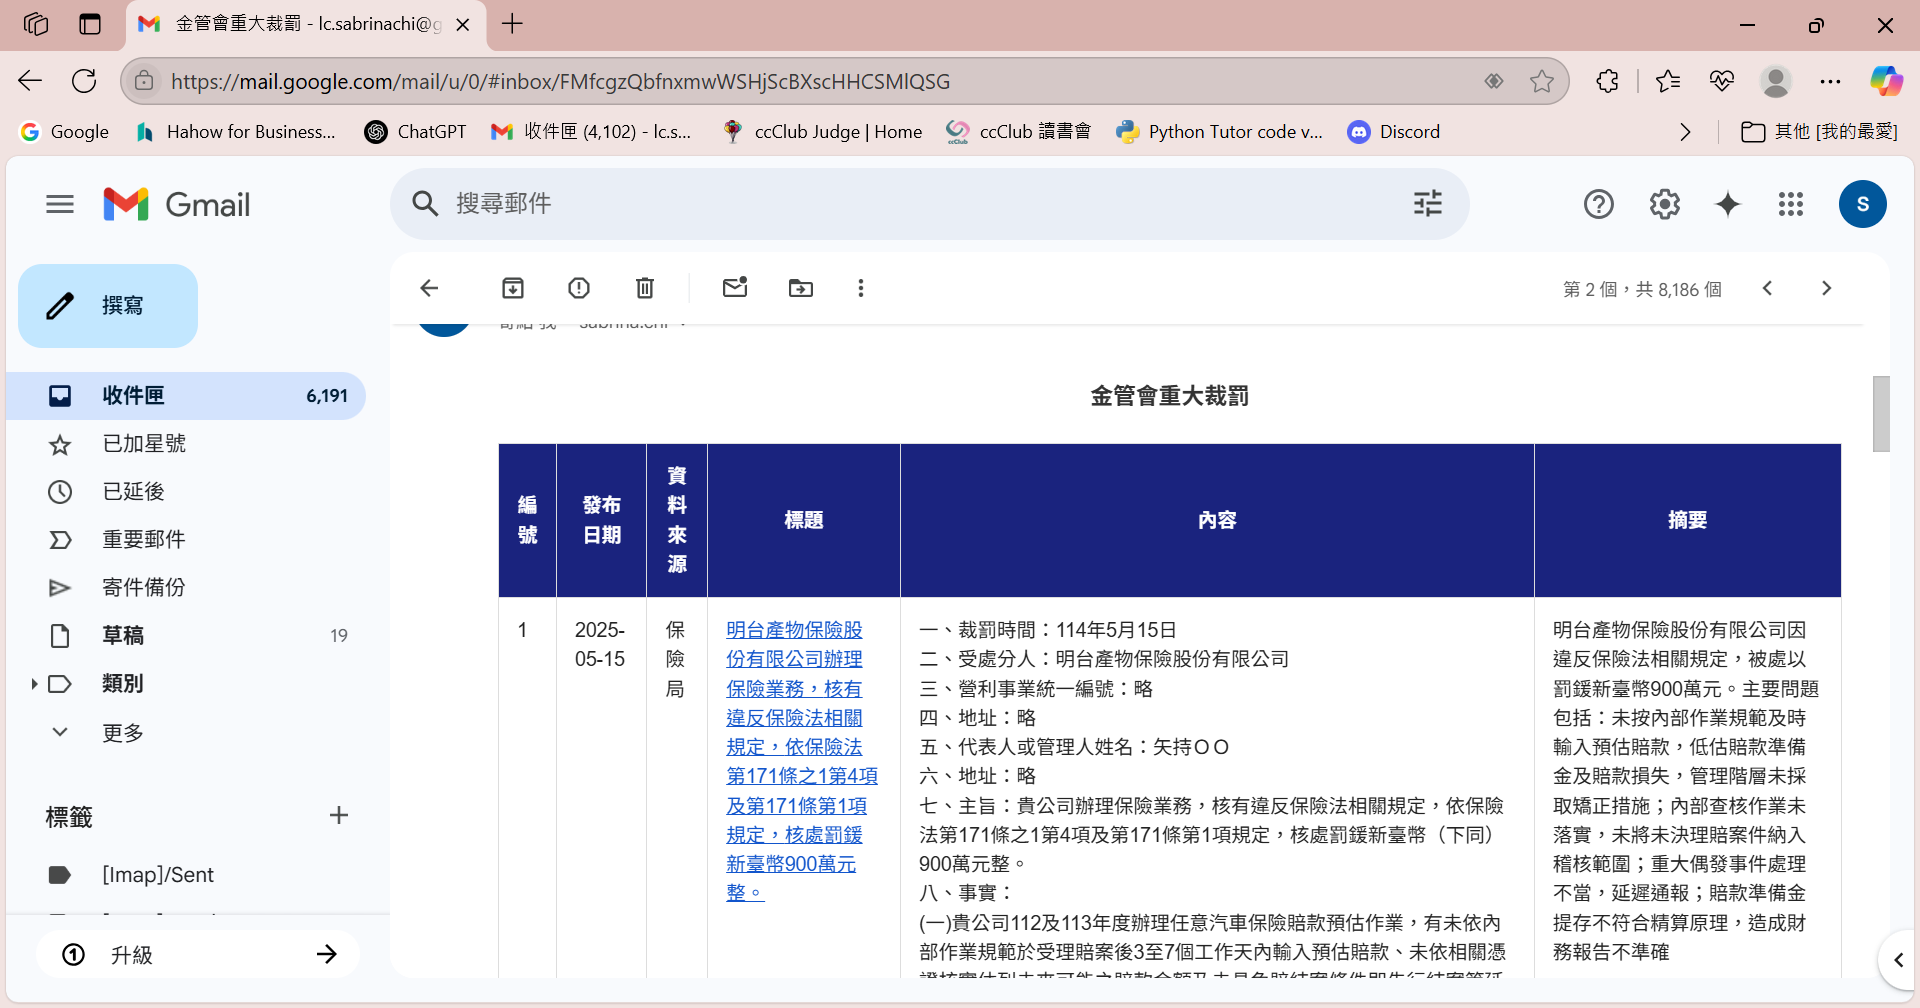